In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from network1 import *

# System Parameters

In [2]:
n_ab = np.array([[2,2,2],[2,2,2]]) #n_ab = [[na1,na2,na3],[nb1,nb2,nb3]]

M = n_ab.shape[1] #number of systems
N = 50 #number of samples;
sigma = 0.1  #noise standard deviation

obs = [4,5,6]

# Loading data

In [3]:

e_est = np.load("exp_1/e_single_exp.npy")
r_est = np.load("exp_1/r_single_exp.npy")
x_est = np.load("exp_1/x_single_exp.npy")


e_val = np.load("exp_1/e_validation.npy")
r_val = np.load("exp_1/r_validation.npy")
x_val = np.load("exp_1/x_validation.npy")


##################################################################################################################

### u2 and u3

theta_opt_multiple_GD_Newton = np.load("exp_1/theta_opt_u1u3_multiple_GD_Newton.npy")
costs_opt_multiple_GD_Newton = np.load("exp_1/costs_opt_u1u3_multiple_GD_Newton.npy")

theta_opt_single_GD_Newton = np.load("exp_1/theta_opt_u1u3_single_GD_Newton.npy")
costs_opt_single_GD_Newton = np.load("exp_1/costs_opt_u1u3_single_GD_Newton.npy")

theta_opt_stoc_GD_Newton = np.load("exp_1/theta_opt_u1u3_stoc_GD_Newton.npy")
costs_opt_stoc_GD_Newton = np.load("exp_1/costs_opt_u1u3_stoc_GD_Newton.npy")

### u2 or u3

theta_opt2_multiple_GD_Newton = np.load("exp_1/theta_opt_u1_or_u3_multiple_GD_Newton.npy")
costs_opt2_multiple_GD_Newton = np.load("exp_1/costs_opt_u1_or_u3_multipl_GD_Newton.npy")

theta_opt2_stoc_GD_Newton = np.load("exp_1/theta_opt_u1_or_u3_stoc_GD_Newton.npy")
costs_opt2_stoc_GD_Newton = np.load("exp_1/costs_opt_u1_or_u3_stoc_GD_Newton.npy")


##################################################################################################################

### Real System:
sys1 = signal.zpk2tf([],[-2, -2], 0.5)
sys2 = signal.zpk2tf([],[-0.5, -1.5], 1)
sys3 = signal.zpk2tf([],[-0.5, -0.5], 0.5)


sys1 = signal.cont2discrete(sys1,1)
sys2 = signal.cont2discrete(sys2,1)
sys3 = signal.cont2discrete(sys3,1)

def compute_fit(x_est,x_real):
    return 1-np.linalg.norm(x_real-x_est)/np.linalg.norm(x_real-x_real.mean())


theta_real = np.concatenate([sys1[1][1:],sys2[1][1:],sys3[1][1:],sys1[0][0,:],sys2[0][0,:],sys3[0][0,:]])


In [4]:
len(theta_opt_multiple_GD_Newton),len(theta_opt_single_GD_Newton),len(theta_opt_stoc_GD_Newton),len(theta_opt2_multiple_GD_Newton),len(theta_opt2_stoc_GD_Newton)

(100, 100, 100, 100, 100)

In [5]:
# REAL:
xo_real,xm_real,_ = get_xoxm(x_val,obs,500,M)

# Cost for stochastic

In [6]:
n_ab = np.array([[2,2,2],[2,2,2]]) #n_ab = [[na1,na2,na3],[nb1,nb2,nb3]]

M = n_ab.shape[1] #number of systems
N = 50 #number of samples;
n_exp = 10 #number of experiments
sigma = 0.1  #noise standard deviation

lam = 0.1


#Interconections
Lamb = jnp.array([[0,1,1],[0,0,0],[1,0,0]])
Delta = jnp.eye(3)


########## Loading data:

e_10 = np.load("exp_1/e_10_exp.npy")
r_10 = np.load("exp_1/r_10_exp.npy")
x_10 = np.load("exp_1/x_10_exp.npy")

def load_all_data(Lamb,Delta,M,N):
    n_obs = 2
    n_exp = 10
    obs = [4,6]

    for i in range(n_exp):
        if i >= 10 :
            j = i%10
        else:
            j = i

        if i == 0:
            r = r_10[j,:,:]
            x = x_10[j,:,:]
            r_sig = jnp.concatenate([r[:,0],r[:,1],r[:,2]]).reshape(-1,1)
            obs_def = obs
        else:
            r = r_10[j,:,:]
            x = jnp.block([[x],[x_10[j,:,:]]])
            r_sig = jnp.block([[r_sig],[jnp.concatenate([r[:,0],r[:,1],r[:,2]]).reshape(-1,1)]])
            obs_def = jnp.concatenate([jnp.array(obs_def),jnp.array(obs)+i*M*2])
            
  
    xo,_,Permut = get_xoxm_multiple_exp(x,obs_def,N,M,n_exp)

    A2,B2 = gen_A2B2_multiple_exp(n_exp,Lamb,Delta,Permut,M,N,r_sig)
    A2o = A2[:,:n_obs*n_exp*N]
    A2m = A2[:,n_obs*n_exp*N:]
    To_phi, Tm_phi, T_gamma, W2, V2 = get_transform_matrices(A2o,A2m,B2)
    return To_phi, Tm_phi, T_gamma, W2, xo.reshape(-1,1), Permut


def load_all_data2(Lamb,Delta,M,N):
    n_obs = 1
    n_exp = 10
    obs = [6]

    for i in range(n_exp):
        if i >= 10 :
            j = i%10
        else:
            j = i

        if i%2 == 0:
            obs = [6]
        else:
            obs = [4]

        if i == 0:
            r = r_10[j,:,:]
            x = x_10[j,:,:]
            r_sig = jnp.concatenate([r[:,0],r[:,1],r[:,2]]).reshape(-1,1)
            obs_def = obs
        else:
            r = r_10[j,:,:]
            x = jnp.block([[x],[x_10[j,:,:]]])
            r_sig = jnp.block([[r_sig],[jnp.concatenate([r[:,0],r[:,1],r[:,2]]).reshape(-1,1)]])
            obs_def = jnp.concatenate([jnp.array(obs_def),jnp.array(obs)+i*M*2])
            

    #n_obs_total = n_exp*n_obs    
    xo,_,Permut = get_xoxm_multiple_exp(x,obs_def,N,M,n_exp)

    A2,B2 = gen_A2B2_multiple_exp(n_exp,Lamb,Delta,Permut,M,N,r_sig)
    A2o = A2[:,:n_obs*n_exp*N]
    A2m = A2[:,n_obs*n_exp*N:]
    To_phi, Tm_phi, T_gamma, W2, V2 = get_transform_matrices(A2o,A2m,B2)
    return To_phi, Tm_phi, T_gamma, W2, xo.reshape(-1,1), Permut

In [7]:
To_phi, Tm_phi, T_gamma, W2, xo, Permut = load_all_data(Lamb,Delta,M,N)

In [8]:
To_phi2, Tm_phi2, T_gamma2, W22, xo2, Permut2 = load_all_data2(Lamb,Delta,M,N)

In [9]:
costs_opt_stoc_GD_Newton = []
for theta in theta_opt_stoc_GD_Newton:
    cost = eval_cost_func_multiple_exp(theta,n_ab,Permut,N,M,n_exp,To_phi, Tm_phi, T_gamma, W2, xo)
    costs_opt_stoc_GD_Newton.append(cost)
costs_opt_stoc_GD_Newton = np.array(costs_opt_stoc_GD_Newton)

In [10]:
costs_opt2_stoc_GD_Newton = []
for theta in theta_opt2_stoc_GD_Newton:
    cost  = eval_cost_func_multiple_exp(theta,n_ab,Permut2,N,M,n_exp,To_phi2, Tm_phi2, T_gamma2, W22, xo2)
    costs_opt2_stoc_GD_Newton.append(cost)
costs_opt2_stoc_GD_Newton = np.array(costs_opt2_stoc_GD_Newton)

# Plot costs

## u1 and u3

In [11]:
N = 500

In [12]:
best_i_multiple_GD_Newton = costs_opt_multiple_GD_Newton.argsort()
best_i_single_GD_Newton = costs_opt_single_GD_Newton.argsort()
best_i_stoc_GD_Newton = costs_opt_stoc_GD_Newton.argsort()

In [13]:
fit_xo_multiple_GD_Newton = []
fit_xm_multiple_GD_Newton = []
for experiment in best_i_multiple_GD_Newton:
    a,b = get_ab(theta_opt_multiple_GD_Newton[experiment],n_ab)

    sys1_est = (np.append(0,b[0]).reshape(-1),np.append([1],a[0]),1)
    sys2_est = (np.append(0,b[1]).reshape(-1),np.append([1],a[1]),1)
    sys3_est = (np.append(0,b[2]).reshape(-1),np.append([1],a[2]),1)
    state_est = gen_states(sys1_est,sys2_est,sys3_est,r_val)
    xo_est,xm_est,_ = get_xoxm(state_est,obs,N,M)
    fit_xo_multiple_GD_Newton.append(compute_fit(xo_est,xo_real))
    fit_xm_multiple_GD_Newton.append(compute_fit(xm_est,xm_real))
    
    
fit_xo_multiple_GD_Newton = np.array(fit_xo_multiple_GD_Newton)
fit_xm_multiple_GD_Newton = np.array(fit_xm_multiple_GD_Newton)

/Users/jogal/Library/Python/3.9/lib/python/site-packages/scipy/signal/_filter_design.py:1746: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


In [14]:
fit_xo_single_GD_Newton = []
fit_xm_single_GD_Newton = []
for experiment in best_i_single_GD_Newton:
    a,b = get_ab(theta_opt_single_GD_Newton[experiment],n_ab)

    sys1_est = (np.append(0,b[0]).reshape(-1),np.append([1],a[0]),1)
    sys2_est = (np.append(0,b[1]).reshape(-1),np.append([1],a[1]),1)
    sys3_est = (np.append(0,b[2]).reshape(-1),np.append([1],a[2]),1)
    state_est = gen_states(sys1_est,sys2_est,sys3_est,r_val)
    xo_est,xm_est,_ = get_xoxm(state_est,obs,N,M)
    fit_xo_single_GD_Newton.append(compute_fit(xo_est,xo_real))
    fit_xm_single_GD_Newton.append(compute_fit(xm_est,xm_real))
    
    
fit_xo_single_GD_Newton = np.array(fit_xo_single_GD_Newton)
fit_xm_single_GD_Newton = np.array(fit_xm_single_GD_Newton)

In [15]:
fit_xo_stoc_GD_Newton = []
fit_xm_stoc_GD_Newton = []
for experiment in best_i_stoc_GD_Newton:
    a,b = get_ab(theta_opt_stoc_GD_Newton[experiment],n_ab)

    sys1_est = (np.append(0,b[0]).reshape(-1),np.append([1],a[0]),1)
    sys2_est = (np.append(0,b[1]).reshape(-1),np.append([1],a[1]),1)
    sys3_est = (np.append(0,b[2]).reshape(-1),np.append([1],a[2]),1)
    state_est = gen_states(sys1_est,sys2_est,sys3_est,r_val)
    xo_est,xm_est,_ = get_xoxm(state_est,obs,N,M)
    fit_xo_stoc_GD_Newton.append(compute_fit(xo_est,xo_real))
    fit_xm_stoc_GD_Newton.append(compute_fit(xm_est,xm_real))
    
    
fit_xo_stoc_GD_Newton = np.array(fit_xo_stoc_GD_Newton)
fit_xm_stoc_GD_Newton = np.array(fit_xm_stoc_GD_Newton)

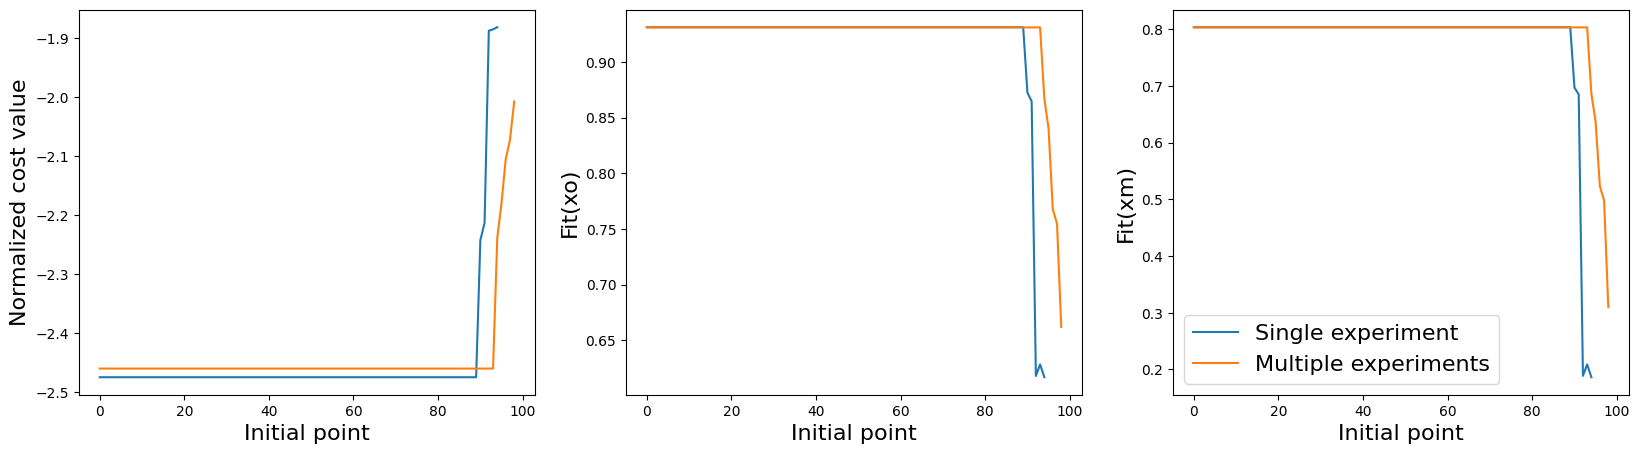

In [16]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20,5)

ax[0].plot(costs_opt_single_GD_Newton[best_i_single_GD_Newton][fit_xo_single_GD_Newton>-1]/1000)#/np.abs(costs_opt_single_GD_Newton[best_i_single_GD_Newton][0]))
ax[0].plot(costs_opt_multiple_GD_Newton[best_i_multiple_GD_Newton][fit_xo_multiple_GD_Newton>-1]/1000)#/np.abs(costs_opt_multiple_GD_Newton[best_i_multiple_GD_Newton][0]))
ax[0].set_xlabel("Initial point",fontsize=16)
ax[0].set_ylabel("Normalized cost value",fontsize=16)

ax[1].plot(fit_xo_single_GD_Newton[fit_xo_single_GD_Newton>-1])
ax[1].plot(fit_xo_multiple_GD_Newton[fit_xo_multiple_GD_Newton>-1])
ax[1].set_xlabel("Initial point",fontsize=16)
ax[1].set_ylabel("Fit(xo)",fontsize=16)

ax[2].plot(fit_xm_single_GD_Newton[fit_xo_single_GD_Newton>-1])
ax[2].plot(fit_xm_multiple_GD_Newton[fit_xo_multiple_GD_Newton>-1])
ax[2].set_xlabel("Initial point",fontsize=16)
ax[2].set_ylabel("Fit(xm)",fontsize=16)
plt.legend(['Single experiment','Multiple experiments'],fontsize=16)

#plt.savefig("cost_fit_single_multiple.pdf")

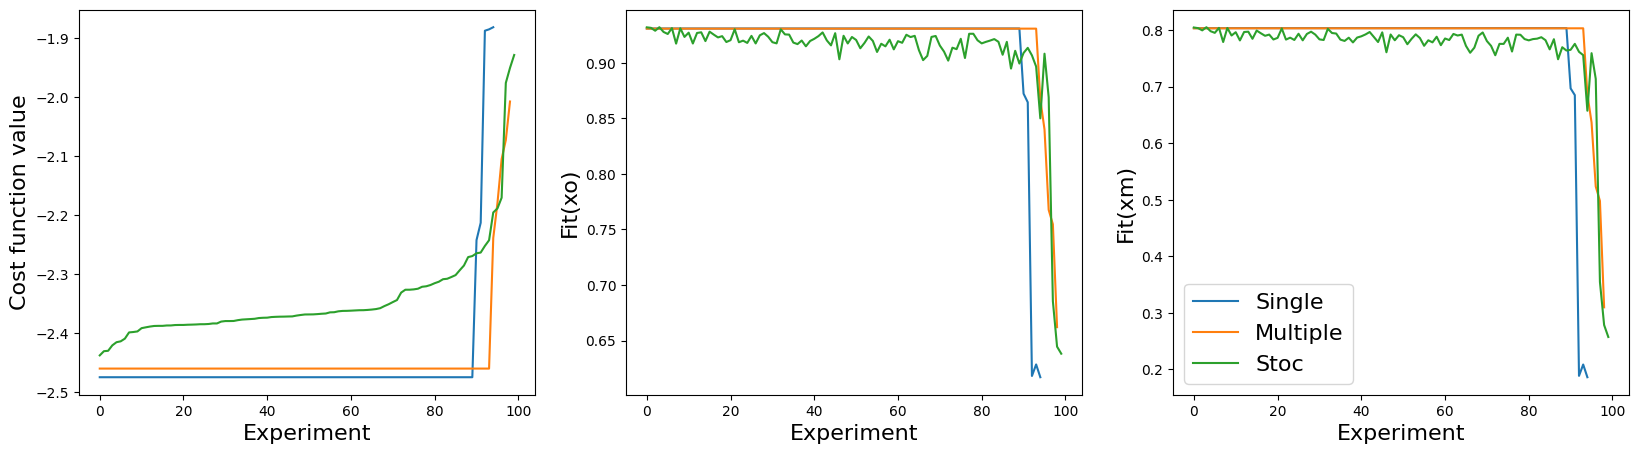

In [17]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20,5)

ax[0].plot(costs_opt_single_GD_Newton[best_i_single_GD_Newton][fit_xo_single_GD_Newton>-1]/1000)#/np.abs(costs_opt_single_GD_Newton[best_i_single_GD_Newton][0]))
ax[0].plot(costs_opt_multiple_GD_Newton[best_i_multiple_GD_Newton][fit_xo_multiple_GD_Newton>-1]/1000)#/np.abs(costs_opt_multiple_GD_Newton[best_i_multiple_GD_Newton][0]))
ax[0].plot(costs_opt_stoc_GD_Newton[best_i_stoc_GD_Newton][fit_xo_stoc_GD_Newton>-1]/1000)#/np.abs(costs_opt_stoc_GD_Newton[best_i_stoc_GD_Newton][0]))
ax[0].set_xlabel("Experiment",fontsize=16)
ax[0].set_ylabel("Cost function value",fontsize=16)

ax[1].plot(fit_xo_single_GD_Newton[fit_xo_single_GD_Newton>-1])
ax[1].plot(fit_xo_multiple_GD_Newton[fit_xo_multiple_GD_Newton>-1])
ax[1].plot(fit_xo_stoc_GD_Newton[fit_xo_stoc_GD_Newton>-1])
ax[1].set_xlabel("Experiment",fontsize=16)
ax[1].set_ylabel("Fit(xo)",fontsize=16)

ax[2].plot(fit_xm_single_GD_Newton[fit_xo_single_GD_Newton>-1])
ax[2].plot(fit_xm_multiple_GD_Newton[fit_xo_multiple_GD_Newton>-1])
ax[2].plot(fit_xm_stoc_GD_Newton[fit_xo_stoc_GD_Newton>-1])
ax[2].set_xlabel("Experiment",fontsize=16)
ax[2].set_ylabel("Fit(xm)",fontsize=16)
plt.legend(['Single','Multiple','Stoc'],fontsize=16)

#plt.savefig("cost_fit.pdf")

In [18]:
fit_xo_single_GD_Newton[0],fit_xo_multiple_GD_Newton[0],fit_xo_stoc_GD_Newton[0]

(0.9310619526007634, 0.9309091066306776, 0.9320745841933673)

In [19]:
fit_xm_single_GD_Newton[0],fit_xm_multiple_GD_Newton[0],fit_xm_stoc_GD_Newton[0]

(0.8032489827240277, 0.8029535187092567, 0.804385335107642)

## u1 or u3

In [20]:
best_i2_multiple_GD_Newton = costs_opt2_multiple_GD_Newton.argsort()
best_i2_stoc_GD_Newton = costs_opt2_stoc_GD_Newton.argsort()

In [21]:
fit_xo2_multiple_GD_Newton = []
fit_xm2_multiple_GD_Newton = []
for experiment in best_i2_multiple_GD_Newton:
    a,b = get_ab(theta_opt2_multiple_GD_Newton[experiment],n_ab)

    sys1_est = (np.append(0,b[0]).reshape(-1),np.append([1],a[0]),1)
    sys2_est = (np.append(0,b[1]).reshape(-1),np.append([1],a[1]),1)
    sys3_est = (np.append(0,b[2]).reshape(-1),np.append([1],a[2]),1)
    state_est = gen_states(sys1_est,sys2_est,sys3_est,r_val)
    xo_est,xm_est,_ = get_xoxm(state_est,obs,N,M)
    fit_xo2_multiple_GD_Newton.append(compute_fit(xo_est,xo_real))
    fit_xm2_multiple_GD_Newton.append(compute_fit(xm_est,xm_real))
    
    
fit_xo2_multiple_GD_Newton = np.array(fit_xo2_multiple_GD_Newton)
fit_xm2_multiple_GD_Newton = np.array(fit_xm2_multiple_GD_Newton)

In [22]:
fit_xo2_stoc_GD_Newton = []
fit_xm2_stoc_GD_Newton = []
for experiment in best_i2_stoc_GD_Newton:
    a,b = get_ab(theta_opt2_stoc_GD_Newton[experiment],n_ab)
    sys1_est = (np.append(0,b[0]).reshape(-1),np.append([1],a[0]),1)
    sys2_est = (np.append(0,b[1]).reshape(-1),np.append([1],a[1]),1)
    sys3_est = (np.append(0,b[2]).reshape(-1),np.append([1],a[2]),1)
    try:
        state_est = gen_states(sys1_est,sys2_est,sys3_est,r_val)
        xo_est,xm_est,_ = get_xoxm(state_est,obs,N,M)
        fit_xo2_stoc_GD_Newton.append(compute_fit(xo_est,xo_real))
        fit_xm2_stoc_GD_Newton.append(compute_fit(xm_est,xm_real))
    except:
        fit_xo2_stoc_GD_Newton.append(np.NAN)
        fit_xm2_stoc_GD_Newton.append(np.NAN)
        
    
    
fit_xo2_stoc_GD_Newton = np.array(fit_xo2_stoc_GD_Newton)
fit_xm2_stoc_GD_Newton = np.array(fit_xm2_stoc_GD_Newton)

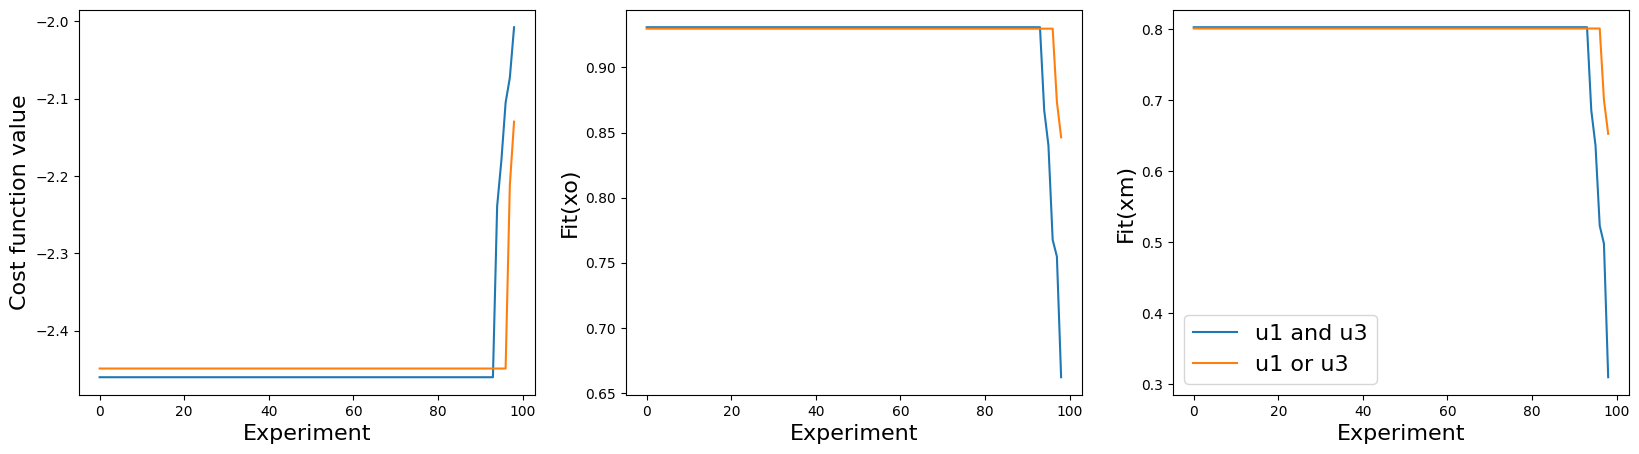

In [23]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20,5)

ax[0].plot(costs_opt_multiple_GD_Newton[best_i_multiple_GD_Newton][fit_xo_multiple_GD_Newton>-1]/1000)#/np.abs(costs_opt_multiple_GD_Newton[best_i_multiple_GD_Newton][0]))
ax[0].plot(costs_opt2_multiple_GD_Newton[best_i2_multiple_GD_Newton][fit_xo2_multiple_GD_Newton>-1]/500)#/np.abs(costs_opt2_multiple_GD_Newton[best_i2_multiple_GD_Newton][0]))
ax[0].set_xlabel("Experiment",fontsize=16)
ax[0].set_ylabel("Cost function value",fontsize=16)


ax[1].plot(fit_xo_multiple_GD_Newton[fit_xo_multiple_GD_Newton>-1])
ax[1].plot(fit_xo2_multiple_GD_Newton[fit_xo2_multiple_GD_Newton>-1])
ax[1].set_xlabel("Experiment",fontsize=16)
ax[1].set_ylabel("Fit(xo)",fontsize=16)

ax[2].plot(fit_xm_multiple_GD_Newton[fit_xo_multiple_GD_Newton>-1])
ax[2].plot(fit_xm2_multiple_GD_Newton[fit_xo2_multiple_GD_Newton>-1])
ax[2].set_xlabel("Experiment",fontsize=16)
ax[2].set_ylabel("Fit(xm)",fontsize=16)
plt.legend(['u1 and u3','u1 or u3'],fontsize=16)

#plt.savefig("cost_fit.pdf")

In [24]:
fit_xo2_multiple_GD_Newton[0],fit_xo2_stoc_GD_Newton[0]

(0.9297969499837616, 0.9245259123499702)

In [25]:
fit_xm2_multiple_GD_Newton[0],fit_xm2_stoc_GD_Newton[0]

(0.8011496010051605, 0.795383344500981)

In [26]:
accuraccy_multiple_GD_Newton = np.load("exp_1/accuracy_u1u3_multiple_GD_Newton.npy")
accuraccy_single_GD_Newton = np.load("exp_1/accuracy_u1u3_single_GD_Newton.npy")
accuraccy2_multiple_GD_Newton = np.load("exp_1/accuracy_u1_or_u3_multiple_GD_Newton.npy")

print(accuraccy_multiple_GD_Newton[accuraccy_multiple_GD_Newton==1].sum())
print(accuraccy_single_GD_Newton[accuraccy_single_GD_Newton==1].sum())
print(accuraccy2_multiple_GD_Newton[accuraccy2_multiple_GD_Newton==1].sum())

93
89
95


# Some Analysis

In [27]:
data = np.block([fit_xo_multiple_GD_Newton.reshape(-1,1),fit_xm_multiple_GD_Newton.reshape(-1,1)])
multiple_df = pd.DataFrame(data=data, columns=["fit_xo","fit_xm"])

data = np.block([fit_xo_single_GD_Newton.reshape(-1,1),fit_xm_single_GD_Newton.reshape(-1,1)])
single_df = pd.DataFrame(data=data, columns=["fit_xo","fit_xm"])

data = np.block([fit_xo_stoc_GD_Newton.reshape(-1,1),fit_xm_stoc_GD_Newton.reshape(-1,1)])
stoc_df = pd.DataFrame(data=data, columns=["fit_xo","fit_xm"])

###

data = np.block([fit_xo2_multiple_GD_Newton.reshape(-1,1),fit_xm2_multiple_GD_Newton.reshape(-1,1)])
multiple2_df = pd.DataFrame(data=data, columns=["fit_xo","fit_xm"])

data = np.block([fit_xo2_stoc_GD_Newton.reshape(-1,1),fit_xm2_stoc_GD_Newton.reshape(-1,1)])
stoc2_df = pd.DataFrame(data=data, columns=["fit_xo","fit_xm"])

print(len(multiple_df[multiple_df["fit_xo"]>=0.9][multiple_df["fit_xm"]>=0.8]))
print(len(single_df[multiple_df["fit_xo"]>=0.9][single_df["fit_xm"]>=0.8]))
print(len(stoc_df[stoc_df["fit_xo"]>=0.9][stoc_df["fit_xm"]>=0.8]))
print("\n\n")
print(len(multiple2_df[multiple2_df["fit_xo"]>=0.9][multiple2_df["fit_xm"]>=0.8]))
print(len(stoc2_df[stoc2_df["fit_xo"]>=0.9][stoc2_df["fit_xm"]>=0.8]))

94
90
7



97
0


/var/folders/m0/xm0qd32n1p7c4cyzsvczw46r0000gn/T/ipykernel_58271/3810367693.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(multiple_df[multiple_df["fit_xo"]>=0.9][multiple_df["fit_xm"]>=0.8]))
/var/folders/m0/xm0qd32n1p7c4cyzsvczw46r0000gn/T/ipykernel_58271/3810367693.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(single_df[multiple_df["fit_xo"]>=0.9][single_df["fit_xm"]>=0.8]))
/var/folders/m0/xm0qd32n1p7c4cyzsvczw46r0000gn/T/ipykernel_58271/3810367693.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(stoc_df[stoc_df["fit_xo"]>=0.9][stoc_df["fit_xm"]>=0.8]))
/var/folders/m0/xm0qd32n1p7c4cyzsvczw46r0000gn/T/ipykernel_58271/3810367693.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(multiple2_df[multiple2_df["fit_xo"]>=0.9][multiple2_df["fit_xm"]>=0.8]))
/var/folders/m0/xm0qd32n1p7c4cyzsvczw46r0000gn/T/

In [28]:
conv_single = 0;
conv_multiple = 0;
conv_stoc = 0;

conv_multiple2 = 0;
conv_stoc2 = 0;

ep = 0.0000001


for item in theta_opt_single_GD_Newton:
    if np.linalg.norm(theta_opt_single_GD_Newton[best_i_single_GD_Newton[0]]-item)<ep:
        conv_single +=1
        
for item in theta_opt_multiple_GD_Newton:
    if np.linalg.norm(theta_opt_multiple_GD_Newton[best_i_multiple_GD_Newton[0]]-item)<ep:
        conv_multiple +=1
    
for item in theta_opt_stoc_GD_Newton:
    if np.linalg.norm(theta_opt_stoc_GD_Newton[best_i_stoc_GD_Newton[0]]-item)<ep:
        conv_stoc +=1
        
        
for item in theta_opt2_multiple_GD_Newton:
    if np.linalg.norm(theta_opt2_multiple_GD_Newton[best_i2_multiple_GD_Newton[0]]-item)<ep:
        conv_multiple2 +=1
        
        
for item in theta_opt2_stoc_GD_Newton:
    if np.linalg.norm(theta_opt2_stoc_GD_Newton[best_i2_stoc_GD_Newton[0]]-item)<ep:
        conv_stoc2 +=1;


In [29]:
conv_single,conv_multiple,conv_stoc

(89, 94, 1)

In [30]:
conv_multiple2,conv_stoc2

(97, 1)

In [31]:
conv_single = 0;
conv_multiple = 0;
conv_stoc = 0;

conv_multiple2 = 0;
conv_stoc2 = 0;

ep = 0.000001


for item in costs_opt_single_GD_Newton:
    if np.linalg.norm(costs_opt_single_GD_Newton[best_i_single_GD_Newton[0]]-item)<ep:
        conv_single +=1
        
for item in costs_opt_multiple_GD_Newton:
    if np.linalg.norm(costs_opt_multiple_GD_Newton[best_i_multiple_GD_Newton[0]]-item)<ep:
        conv_multiple +=1
        
for item in costs_opt_stoc_GD_Newton:
    if np.linalg.norm(costs_opt_stoc_GD_Newton[best_i_stoc_GD_Newton[0]]-item)<ep:
        conv_stoc +=1
        
        
for item in costs_opt2_multiple_GD_Newton:
    if np.linalg.norm(costs_opt2_multiple_GD_Newton[best_i2_multiple_GD_Newton[0]]-item)<ep:
        conv_multiple2 +=1
        
        
for item in costs_opt2_stoc_GD_Newton:
    if np.linalg.norm(costs_opt2_stoc_GD_Newton[best_i2_stoc_GD_Newton[0]]-item)<ep:
        conv_stoc2 +=1;


In [32]:
conv_single,conv_multiple,conv_stoc

(90, 94, 1)

In [33]:
conv_multiple2,conv_stoc2

(97, 1)

# Computing Covariances

## Single - u3 and u1

In [34]:
obs = [4,6]
N = 500

n_obs = len(obs)
xo,_,Permut = get_xoxm(x_est,obs,N,M)

A2,B2 = gen_A2B2(Lamb,Delta,Permut,M,N,r_est.reshape(-1,1))
A2o = A2[:,:n_obs*N]
A2m = A2[:,n_obs*N:]
To_phi, Tm_phi, T_gamma, W2, V2 = get_transform_matrices(A2o,A2m,B2)


fisher_mat = fisher_matrix(theta_opt_single_GD_Newton[best_i_single_GD_Newton[0]],n_ab, Permut, N, M, To_phi, Tm_phi, T_gamma, W2, xo)
cov = np.linalg.inv(fisher_mat)

np.trace(cov),np.max(np.linalg.eigvalsh(cov)),np.linalg.det(cov)

(0.08979084941275531, 0.04843347609499537, 1.0749891341769285e-31)

## Multiple - u3 and u1

In [35]:
obs = [4,6]
N = 50

To_phi, Tm_phi, T_gamma, W2, xo, Permut = load_all_data(Lamb,Delta,M,N)


fisher_mat = fisher_matrix_multi(theta_opt_multiple_GD_Newton[best_i_multiple_GD_Newton[0]],n_ab, Permut, N, M, n_exp, To_phi, Tm_phi, T_gamma, W2, xo)
cov = np.linalg.inv(fisher_mat)

np.trace(cov),np.max(np.linalg.eigvalsh(cov)),np.linalg.det(cov)

(0.005000629860062605, 0.002016141921004219, 6.008123159454691e-51)

## Multiple - u3 or u1

In [36]:
obs = [4,6]
N = 50

To_phi, Tm_phi, T_gamma, W2, xo, Permut = load_all_data2(Lamb,Delta,M,N)


fisher_mat = fisher_matrix_multi(theta_opt2_multiple_GD_Newton[best_i2_multiple_GD_Newton[0]],n_ab, Permut, N, M, n_exp, To_phi, Tm_phi, T_gamma, W2, xo)
cov = np.linalg.inv(fisher_mat)

np.trace(cov),np.max(np.linalg.eigvalsh(cov)),np.linalg.det(cov)

(0.009958125114687478, 0.004186191885689504, 2.019009682472221e-47)